In [1]:
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import numpy as np 
from PIL import Image
from torch.utils.data import DataLoader,Dataset,random_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from os import listdir
from sklearn.model_selection import train_test_split
import pandas as pd
from os.path import isfile, join

In [2]:
from PIL import Image
import requests
from transformers import AutoProcessor, CLIPVisionModel

import warnings
warnings.filterwarnings("ignore")
t.cuda.set_device(8)
device = t.device('cuda' if t.cuda.is_available() else 'cpu')

/raid/amana/miniconda3/envs/lamol/lib/python3.8/site-packages/pydantic/_internal/_config.py:317: UserWarning: Valid config keys have changed in V2:
* 'allow_population_by_field_name' has been renamed to 'populate_by_name'
* 'validate_all' has been renamed to 'validate_default'
  warnings.warn(message, UserWarning)
/raid/amana/miniconda3/envs/lamol/lib/python3.8/site-packages/pydantic/_internal/_fields.py:128: UserWarning: Field "model_persistence_threshold" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/raid/amana/miniconda3/envs/lamol/lib/python3.8/site-packages/pydantic/_internal/_config.py:317: UserWarning: Valid config keys have changed in V2:
* 'validate_all' has been renamed to 'validate_default'
  warnings.warn(message, UserWarning)


In [7]:
audio_train_loader = t.load("/raid/amana/lavish_multi_model/emotion_detection/wave2_vec_diff_classfi_data_train_dataset.pth")
audio_test_loader = t.load("/raid/amana/lavish_multi_model/emotion_detection/wave2_vec_diff_classfi_data_test_dataset.pth")

In [32]:
image_dataset = np.load("/raid/amana/lavish_multi_model/emotion_detection/dataset_clip_image_vectors1.npy",allow_pickle=True)

In [33]:
Xtrain,Xtest,Ytrain,Ytest = train_test_split(image_dataset[:,0],image_dataset[:,1],test_size=0.2)

In [9]:
train_size = int(0.8 * len(image_dataset))
test_size = len(image_dataset) - train_size

train_dataset, test_dataset = random_split(image_dataset, [train_size, test_size])

image_train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
image_test_dataloader = DataLoader(test_dataset, batch_size=1,shuffle=False)

In [41]:
class EmotionMLP(nn.Module):
    def softmax(self,x):
        e_x = t.exp(x - t.max(x))
        return e_x / e_x.sum()
    
    def __init__(self, num_classes):
        super(EmotionMLP, self).__init__()
        self.input_matrix = nn.Parameter(t.rand(49,1))
        self.fc0 = nn.Linear(768,512)
        self.fc1 = nn.Linear(512,64)
        self.fc2 = nn.Linear(64, num_classes)

    def concat(self,x1,x2):
        return x1+x2
    
    def forward(self, x1,x2):
        #image
        x1 = t.matmul(x1.t(),self.input_matrix)
        x1 = x1.view(-1, 512)
        
        #audio
        x2 = t.relu(self.fc0(x2))
        x2 = x2.view(-1, 512)
        
        #concat
        x = self.concat(x1,x2)
        x = t.relu(self.fc1(x))
        x = t.relu(self.fc2(x))
        x = t.sigmoid(x)
        return x

In [42]:
num_classes = 7
model = EmotionMLP(num_classes).to(device)

x1 = t.rand(49,512)
x2 = t.rand(768)
model(x1.to(device),x2.to(device)).shape

torch.Size([1, 7])

In [53]:
num_classes = 7
model = EmotionMLP(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = t.optim.Adam(model.parameters(), lr=0.0001)

In [54]:
def train(model,audio_loader,Xtrain,optimizer,criterion,num_epochs,device):
    loss_arr = []
    for epoch in tqdm(range(num_epochs)):
        # model.train()
        total_loss = 0
        for i,(x,y) in enumerate(audio_loader):
            # Forward pass
            image_input = t.tensor(Xtrain[i][0])
            outputs = model(x.to(device),image_input.to(device))
            loss = criterion(outputs,t.tensor([y]).to(device)).to(device)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        loss_arr.append(total_loss/len(audio_loader))
        if epoch%10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {total_loss/len(audio_loader)}')
    return loss_arr

num_epochs = 30
lossarr = train(model,audio_train_loader,Xtrain,optimizer,criterion,num_epochs,device)

  3%|▎         | 1/30 [00:06<03:21,  6.96s/it]

Epoch 1/30, Training Loss: 1.8325842082909642


 37%|███▋      | 11/30 [01:16<02:13,  7.01s/it]

Epoch 11/30, Training Loss: 1.7860873978525331


 70%|███████   | 21/30 [02:25<01:02,  6.96s/it]

Epoch 21/30, Training Loss: 1.7702725535126518


100%|██████████| 30/30 [03:30<00:00,  7.03s/it]


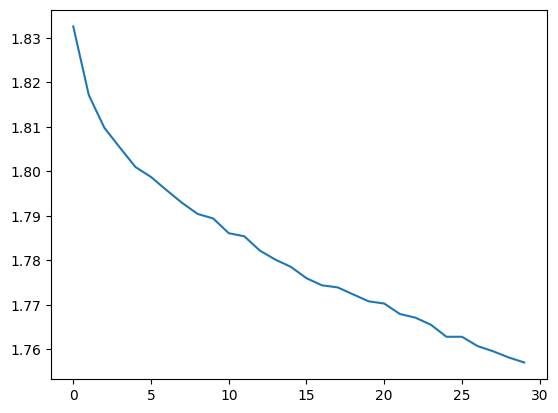

In [55]:
plt.plot(range(30),lossarr)

In [58]:
def test(model,test_loader,Xtest,device):
    
    def accuracy1(y_true, y_pred):
        eq = t.eq(y_true, y_pred).int()
        return sum(eq)/len(eq)
    
    acc = 0
    with t.no_grad():
        model.eval()
        for i,(x,y) in enumerate(test_loader):
            image_input = t.tensor(Xtest[i][0])
            outputs = model(x.to(device),image_input.to(device))
            outputs1 = outputs.detach().cpu()
            outputs2 = t.argmax(outputs1, dim=1)
            acc += accuracy1(t.tensor([y]),outputs2)
        print(f"accuracy: {((acc/len(test_loader))*100)}")
        
test(model,audio_test_loader,Xtest,device)

accuracy: 45.20183563232422
